## All stations models

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import r2_score, mean_absolute_error
import math
from scipy import stats
import re
import json

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
%matplotlib inline
# %run model_utils.ipynb

/Users/tamarahuete/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
### Set fixed variables
input_path = 'data/PROCESSED/STATIONS_CLEAN'
path = 'data/PROCESSED/MODEL_OUTPUTS'

## sampling frequency
sample_freq = 60 #(time in minutes)
steps=int(sample_freq/5)
time_steps = int(60/sample_freq)
#60min - 12 steps
#30min - 6 steps
#15min - 3 steps
#5min - 1 step

MAX_EPOCHS = 20

In [3]:
files_ids = {'guadalupe':'guadalupe_validation.csv',
         'banos':'banos_validation.csv',
         'aeropuerto': 'aeropuerto_validation.csv',
         'quisapincha':'quisapincha_validation.csv',
         'chiquiurco':'chiquiurco_validation.csv',
         'AJSucre':'AJSucre_validation.csv',
         'JAlvarez':'JAlvarez_validation.csv',
         'pfc-hgpt':'pfc-hgpt_validation.csv',
         'calamaca':'calamaca_validation.csv',
         'mulaCorral':'mulaCorral_validation.csv',
         'pampasSalasaca':'pampasSalasaca_validation.csv',
         'tasinteo':'tasinteo_validation.csv',
         'pisayambo':'pisayambo_validation.csv'
         }
## cuchimbamba??

In [4]:
def selectCols(df):
  d = dict(zip(df.columns[1:20],df.columns[1:20]+f'_{station[0:3]}'))
  #df = df[['Date_Time', 'ATAvg', 'RHAvg','WDAvg','WSAvg','WAvgx', 'WAvgy','Day_sin', 'Day_cos', 'Year_sin', 'Year_cos']]
  df = df[['Date_Time', 'ATAvg', 'RHAvg','WSAvg','WAvgx','Day_sin', 'Day_cos']]
  df.rename(columns=d, inplace= True)
  df.set_index('Date_Time', inplace =True)
  df.index = pd.to_datetime(df.index)
  return df

In [5]:
### combine all stations in one df
for idx, station in enumerate(files_ids.keys()):
    if idx == 0:
        df = pd.read_csv(f'{input_path}/{station}_validation.csv')
        merged = selectCols(df)
    else:
        df1 = pd.read_csv(f'{input_path}/{station}_validation.csv')
        df1 = selectCols(df1)
        merged=pd.merge(merged,df1, how='inner', left_index=True, right_index=True)
    

/Users/tamarahuete/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [6]:
merged.columns

Index(['ATAvg_gua', 'RHAvg_gua', 'WDAvg_gua', 'WSAvg_gua', 'WAvgx_gua',
       'WAvgy_gua', 'Day_sin_gua', 'Day_cos_gua', 'Year_sin_gua',
       'Year_cos_gua',
       ...
       'ATAvg_pis', 'RHAvg_pis', 'WDAvg_pis', 'WSAvg_pis', 'WAvgx_pis',
       'WAvgy_pis', 'Day_sin_pis', 'Day_cos_pis', 'Year_sin_pis',
       'Year_cos_pis'],
      dtype='object', length=130)

In [7]:
merged.head()

ATAvg_gua  RHAvg_gua  WDAvg_gua  WSAvg_gua  WAvgx_gua  \
Date_Time                                                                    
2013-05-09 11:45:00     21.708     55.150    182.200      4.195  -4.191908   
2013-05-09 11:50:00     21.728     53.284    182.200      4.195  -4.191908   
2013-05-09 11:55:00     22.090     51.676    182.200      4.195  -4.191908   
2013-05-09 12:00:00     22.190     51.590    180.195      4.630  -4.629973   
2013-05-09 12:05:00     22.106     50.402    180.195      4.630  -4.629973   

                     WAvgy_gua   Day_sin_gua  Day_cos_gua  Year_sin_gua  \
Date_Time                                                                 
2013-05-09 11:45:00  -0.161037  6.540313e-02    -0.997859      0.796429   
2013-05-09 11:50:00  -0.161037  4.361939e-02    -0.999048      0.796393   
2013-05-09 11:55:00  -0.161037  2.181489e-02    -0.999762      0.796356   
2013-05-09 12:00:00  -0.015758  1.373671e-12    -1.000000      0.796320   
2013-05-09 12:05:00  -0.015758 -2.181489e-02    -0.999762      0.796284   

                     Year_cos_gua  ...  ATAvg_pis  RHAvg_pis  WDAvg_pis  \
Date_Time                          ...                                    
2013-05-09 11:45:00     -0.604732  ...      11.25      76.29    134.025   
2013-05-09 11:50:00     -0.604780  ...      11.25      73.37    134.025   
2013-05-09 11:55:00     -0.604828  ...      11.94      76.69    134.025   
2013-05-09 12:00:00     -0.604875  ...      11.60      77.88    132.685   
2013-05-09 12:05:00     -0.604923  ...      11.16      81.37    132.685   

                     WSAvg_pis  WAvgx_pis  WAvgy_pis   Day_sin_pis  \
Date_Time                                                            
2013-05-09 11:45:00       4.63  -3.217721   3.329140  6.540313e-02   
2013-05-09 11:50:00       4.02  -2.793788   2.890527  4.361939e-02   
2013-05-09 11:55:00       4.36  -3.030079   3.135000  2.181489e-02   
2013-05-09 12:00:00       5.79  -3.925430   4.256183  1.373671e-12   
2013-05-09 12:05:00       6.03  -4.088142   4.432605 -2.181489e-02   

                     Day_cos_pis  Year_sin_pis  Year_cos_pis  
Date_Time                                                     
2013-05-09 11:45:00    -0.997859      0.796429     -0.604732  
2013-05-09 11:50:00    -0.999048      0.796393     -0.604780  
2013-05-09 11:55:00    -0.999762      0.796356     -0.604828  
2013-05-09 12:00:00    -1.000000      0.796320     -0.604875  
2013-05-09 12:05:00    -0.999762      0.796284     -0.604923  

[5 rows x 130 columns]

In [8]:
print(f'len = {len(merged)}')
merged.drop_duplicates(keep = 'first',inplace=True)
print(f'len (after duplicate drop = {len(merged)}')

len = 623263
len (after duplicate drop = 623263


In [9]:
merged.isnull().values.any()

False

In [10]:
### Subsample to get data for every hour (starting from index 0, get 12 steps)
df = merged[0::steps]

In [11]:
print(f'starts at = {df.index.min().date()}')
print(f'ends at = {df.index.max().date()}')

starts at = 2013-05-09
ends at = 2019-04-12


In [12]:
## Select variables of interest
r = re.compile(f'ATAvg.*') # only csv files
temp = list(filter(r.match, list(df.columns))) 

r = re.compile(f'RHAvg.*') # only csv files
rh = list(filter(r.match, list(df.columns))) 

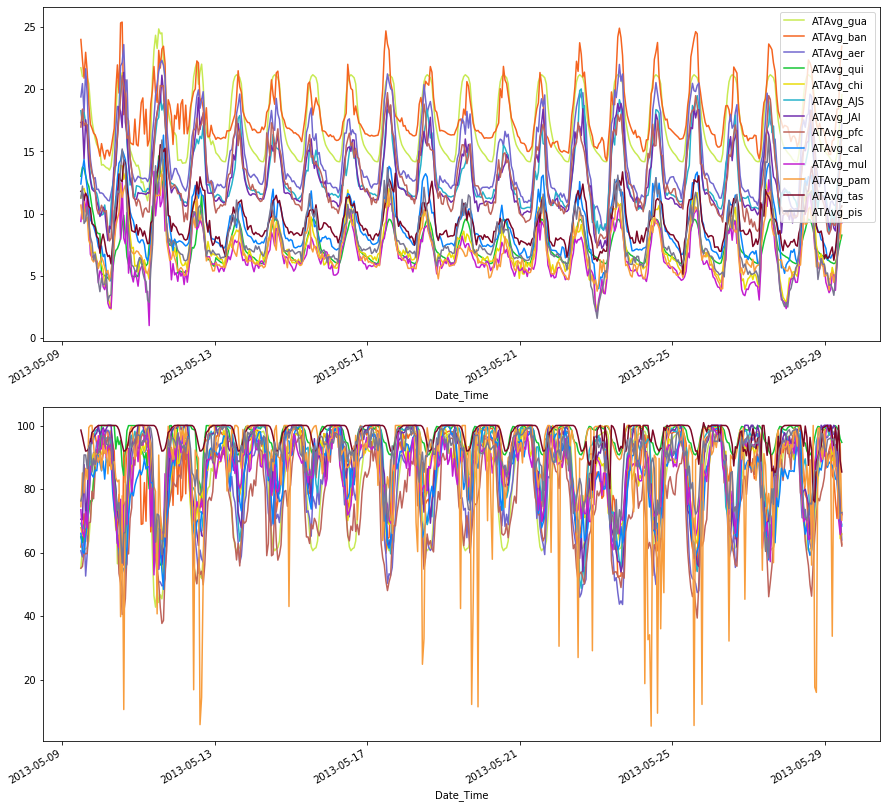

In [41]:
### Plot temperature
 # View corrected values
colors = ['#c8ea53','#f56420','#7167ce','#15c534','#e9dc09','#25b2ca','#702dae','#be645b',
         '#0884fc','#c21ed0','#f89d3d','#7c0725','#797691']
model_color = dict(zip(temp,colors))

fig, axes = plt.subplots(2,1,figsize= (15,15))
for a in range(0,len(temp)):
    df[temp[a]][:480].plot(ax = axes[0],color = model_color[temp[a]])
    df[rh[a]][0:480].plot(ax = axes[1],color = model_color[temp[a]])
    axes[0].legend()
#plt.savefig(f'{path}/{station}_temp_rh.png', dpi = 100,bbox_inches='tight')

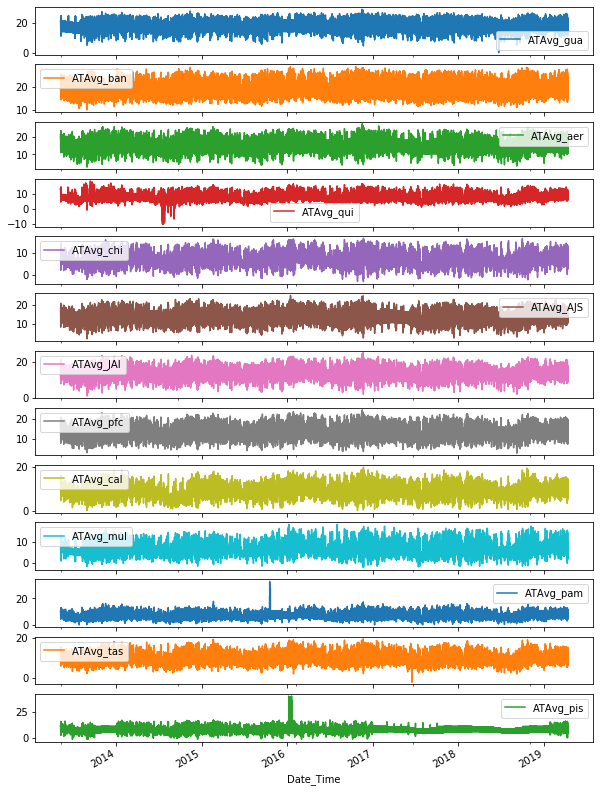

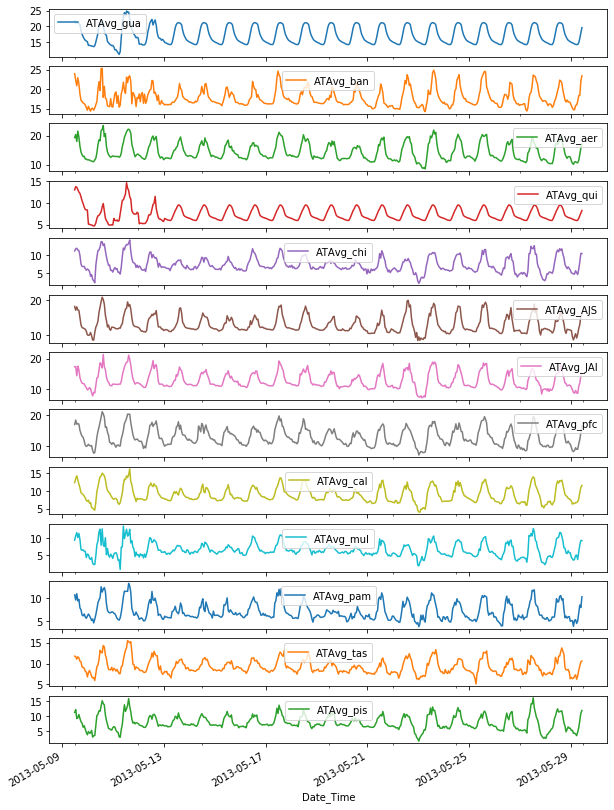

In [13]:
### Plot temperature
plot_cols = temp
plot_features = df[plot_cols]
#plot_features.index = date_time
_ = plot_features.plot(subplots=True, figsize = (10,15))

plot_features = df[plot_cols][:480]
#plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True,figsize = (10,15))

In [14]:
### Split data into 70%, 20%, 10% split for the training, validation, and test sets
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [15]:
### Normalize the data  ### ROOM TO MAKE TESTS (this is just an average)
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

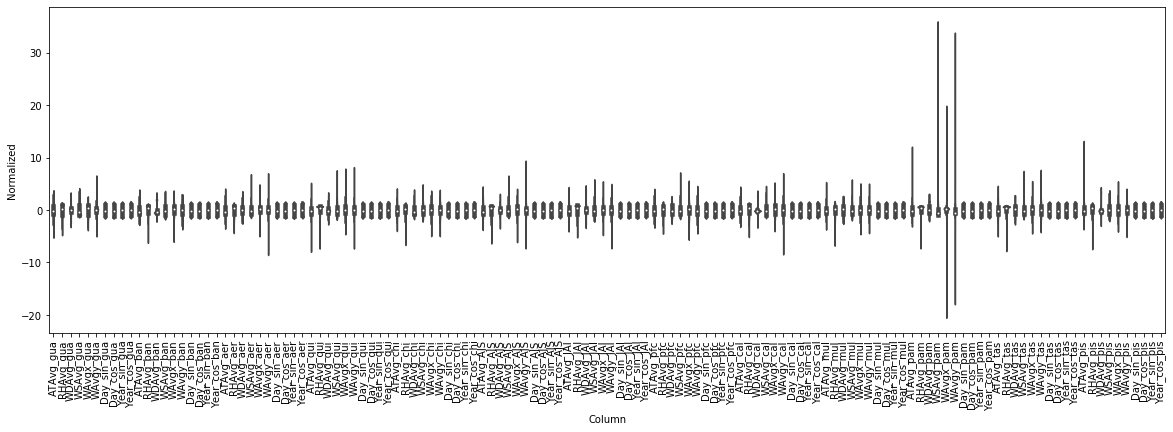

In [16]:
## Feature distributions
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(20, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

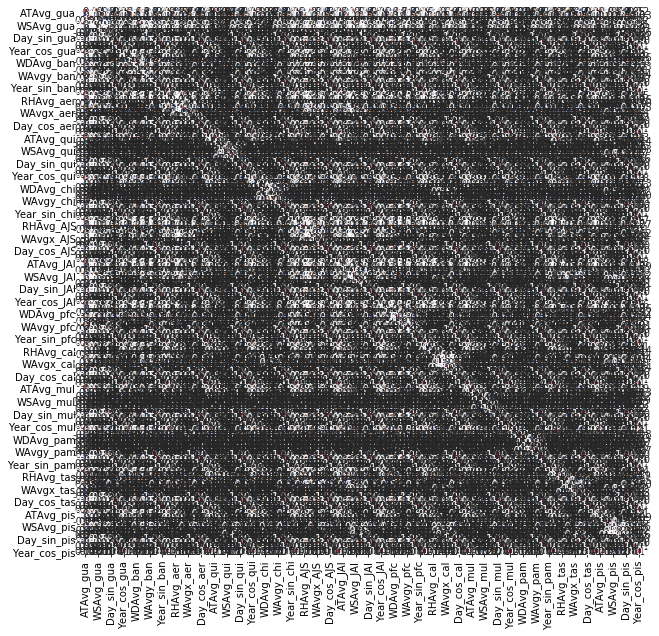

In [17]:
## correlations matrix of variables
df_corr = df.corr()
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(df.corr(), annot=True, fmt='.2f', 
            cmap='coolwarm', cbar=False)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
fig.savefig(f'{path}/all_stations_corrmatrix.png',dpi = 75)

## Run models

In [25]:
## read functions
%run model_utils.ipynb

In [19]:
station = 'all'
num_features = df.shape[1]
vars_to_analize = temp+rh ## get temperature and rel humidity variables

### 24 h + 12h

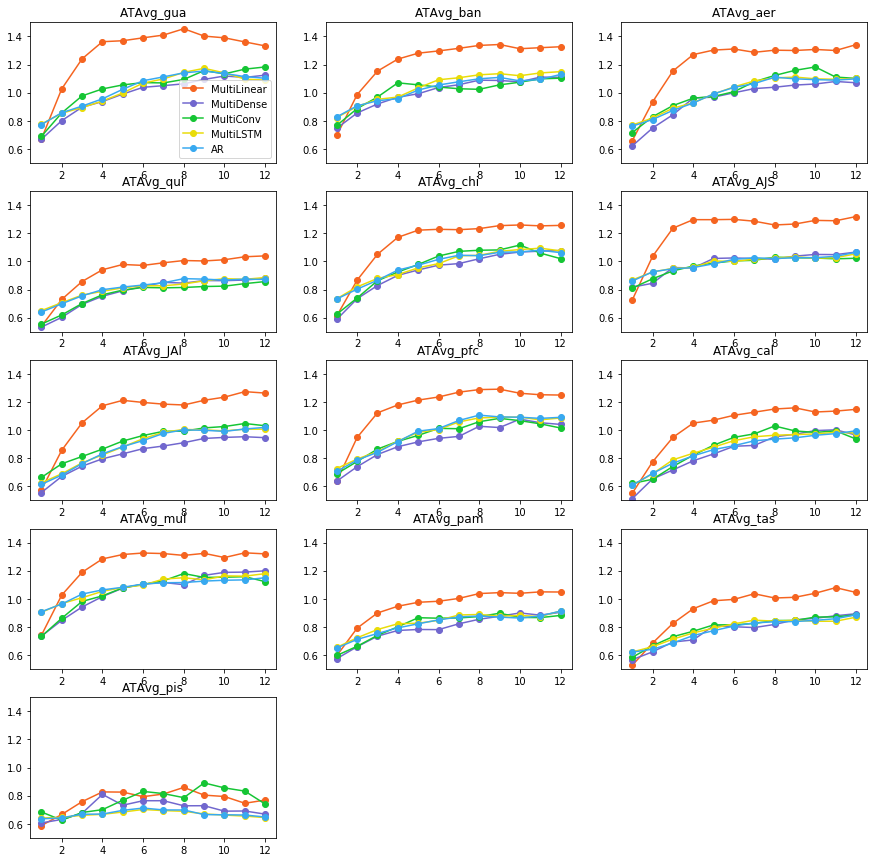

In [24]:
input_width = 24*time_steps
OUT_STEPS =12*time_steps
performance = multi_models(station, path, num_features,input_width, OUT_STEPS)
file = f'{path}/{station}_multi_{sample_freq}m_w{input_width}_{OUT_STEPS}_performance_times.csv'
plot_times(file, y0=0.5, y1=1.5)

### 24 h + 24h

324/324 [==============================] - 1s 4ms/step - loss: 0.3864 - mean_absolute_error: 0.3688


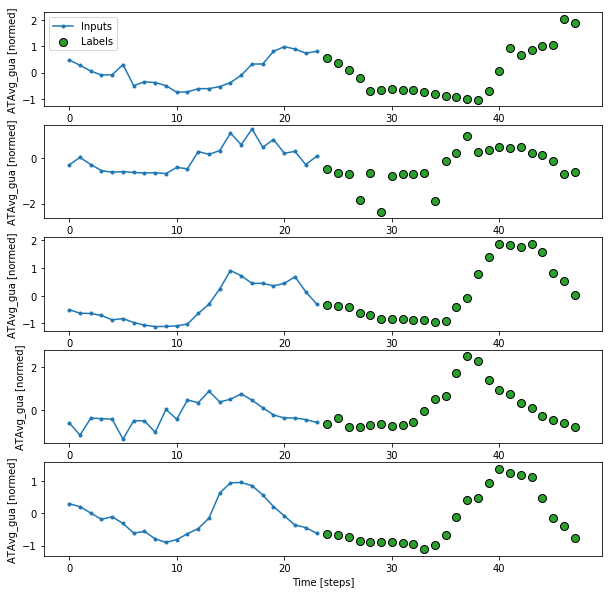

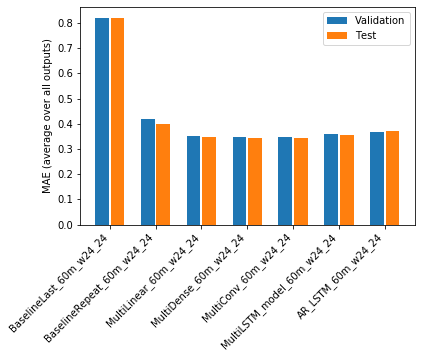

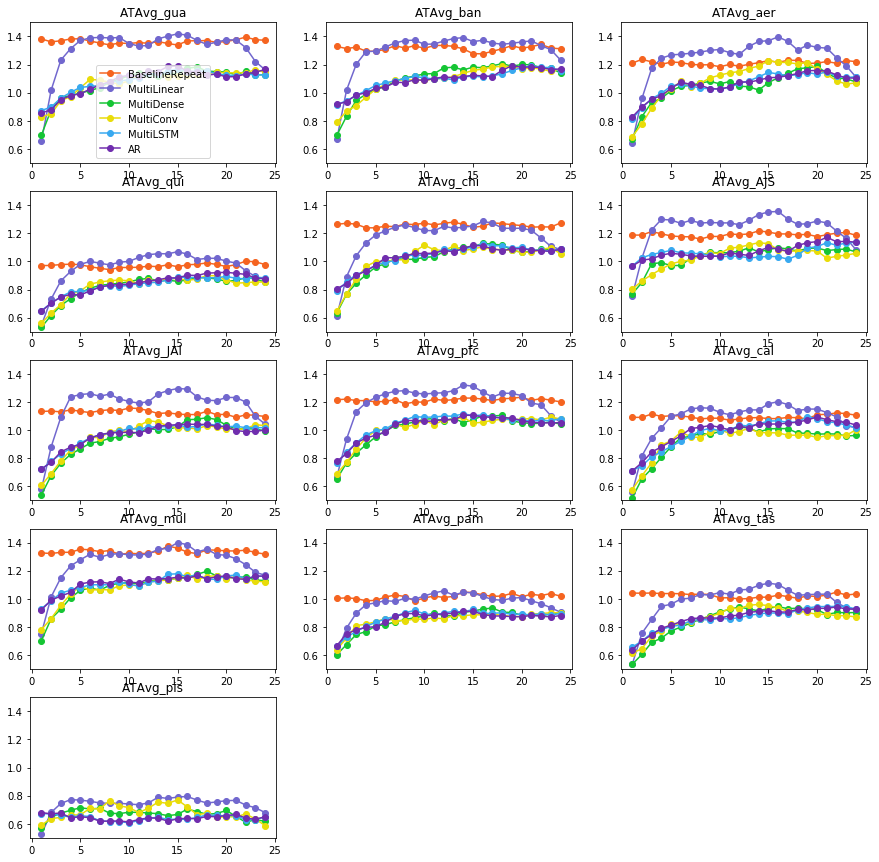

In [26]:
input_width = 24*time_steps
OUT_STEPS = 24*time_steps
performance = multi_models(station, path, num_features,input_width, OUT_STEPS)
file = f'{path}/{station}_multi_{sample_freq}m_w{input_width}_{OUT_STEPS}_performance_times.csv'
plot_times(file, y0=0.5, y1=1.5)

### 48 h + 12h

323/323 [==============================] - 3s 8ms/step - loss: 0.3693 - mean_absolute_error: 0.3578


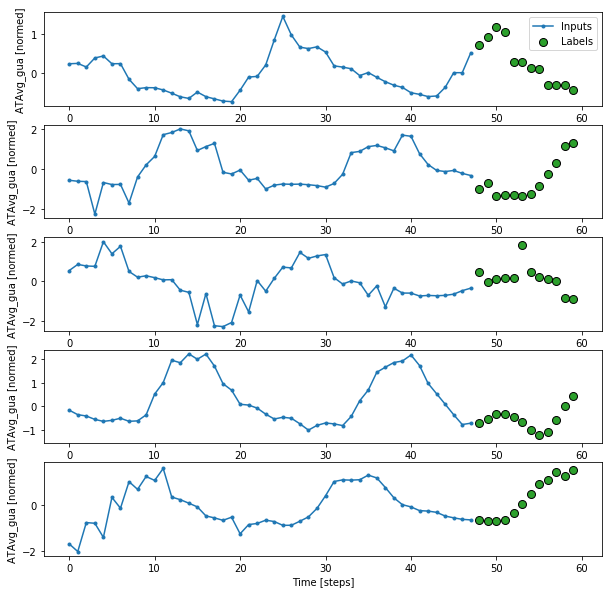

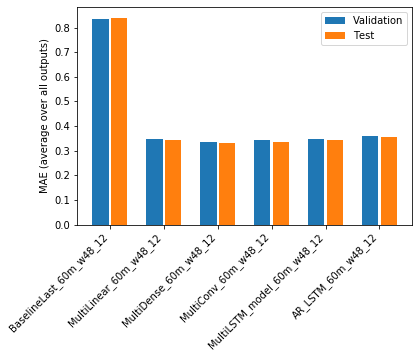

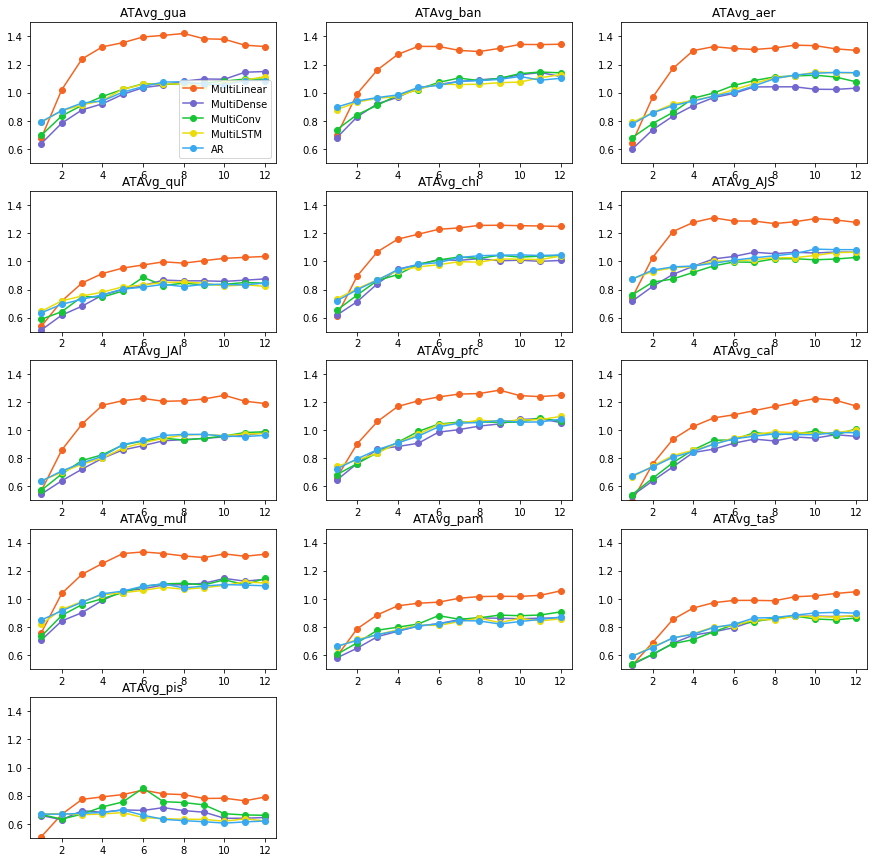

In [42]:
input_width = 48*time_steps
OUT_STEPS = 12*time_steps
performance = multi_models(station, path, num_features,input_width, OUT_STEPS)
file = f'{path}/{station}_multi_{sample_freq}m_w{input_width}_{OUT_STEPS}_performance_times.csv'
plot_times(file, y0=0.5, y1=1.5)

### 48 h + 24h

323/323 [==============================] - 2s 5ms/step - loss: 0.3865 - mean_absolute_error: 0.3718


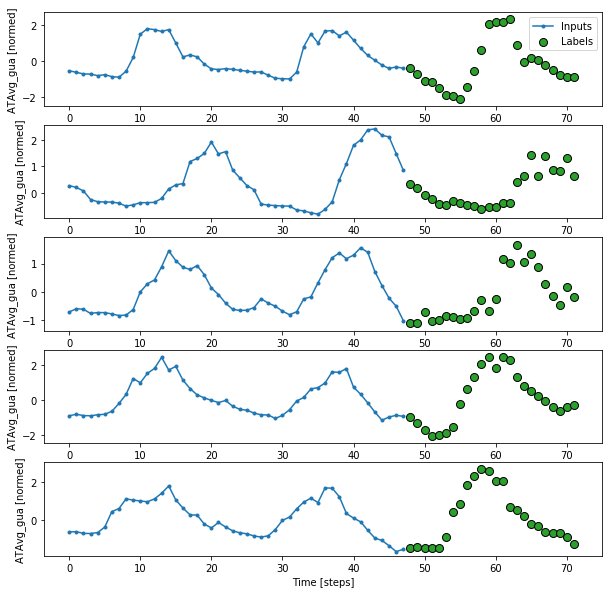

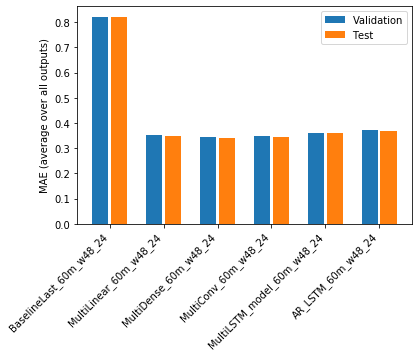

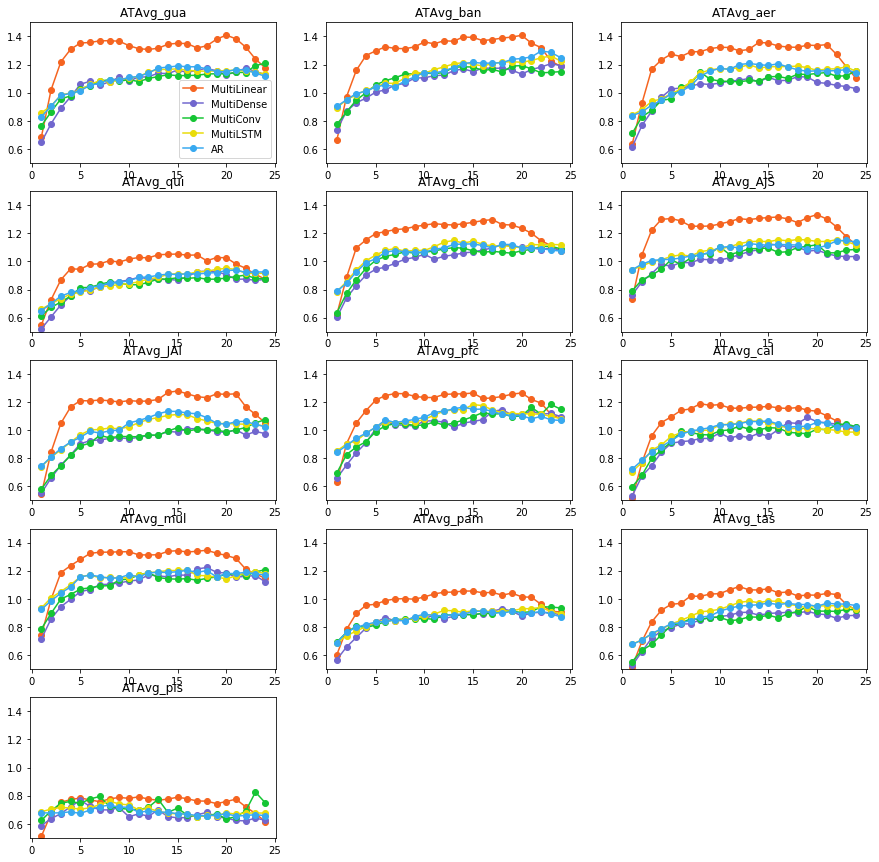

In [27]:
input_width = 48*time_steps
OUT_STEPS = 24*time_steps
performance = multi_models(station, path, num_features,input_width, OUT_STEPS)
file = f'{path}/{station}_multi_{sample_freq}m_w{input_width}_{OUT_STEPS}_performance_times.csv'
plot_times(file, y0=0.5, y1=1.5)

### 48 h + 48h

322/322 [==============================] - 2s 7ms/step - loss: 0.4079 - mean_absolute_error: 0.3868


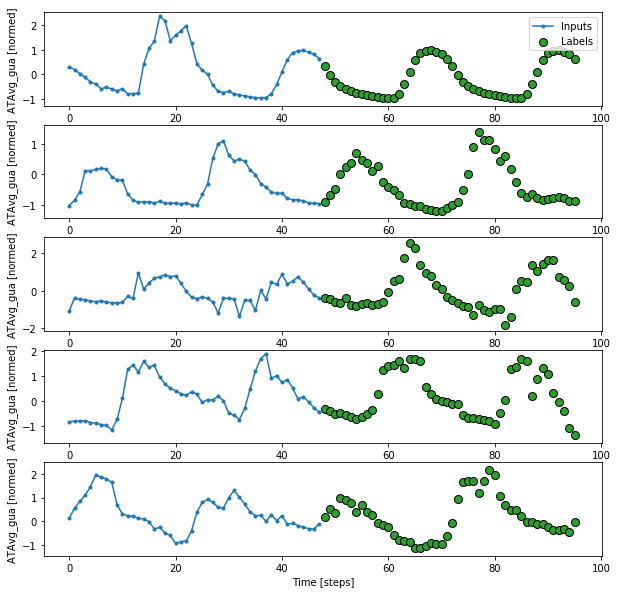

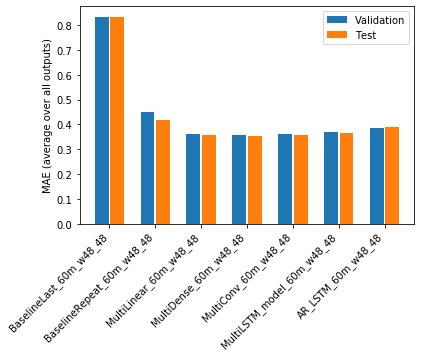

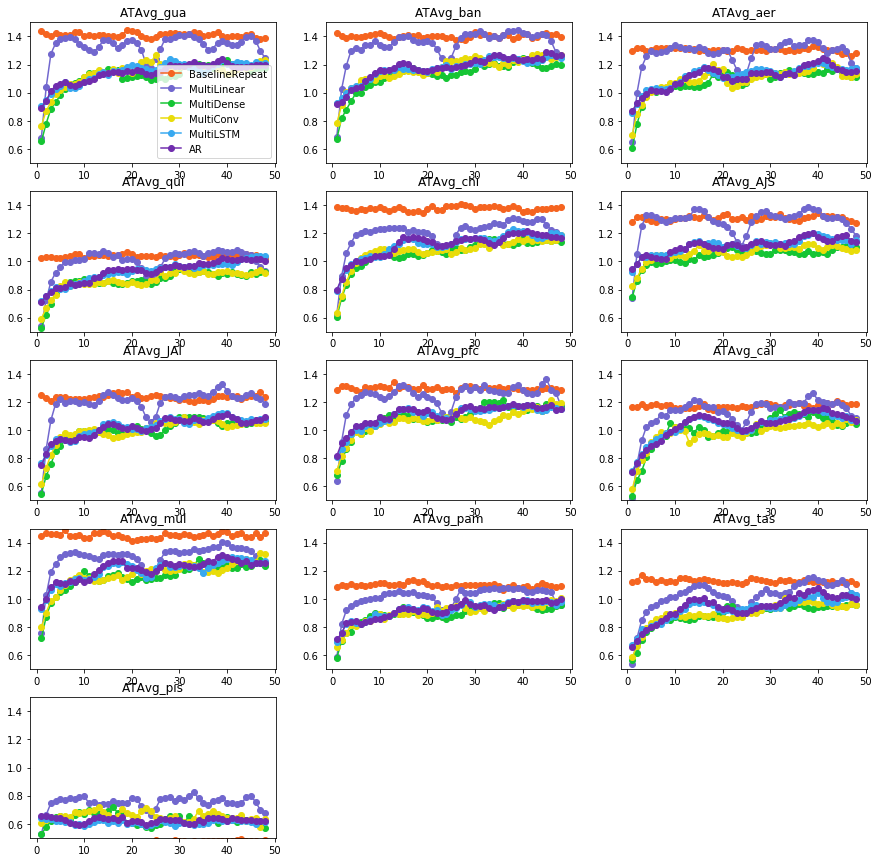

In [28]:
input_width = 48*time_steps
OUT_STEPS = 48*time_steps
performance = multi_models(station, path, num_features,input_width= input_width, OUT_STEPS=OUT_STEPS)
file = f'{path}/{station}_multi_{sample_freq}m_w{input_width}_{OUT_STEPS}_performance_times.csv'
plot_times(file, y0=0.5, y1=1.5)

### 72 h + 12h

323/323 [==============================] - 2s 6ms/step - loss: 0.3673 - mean_absolute_error: 0.3591


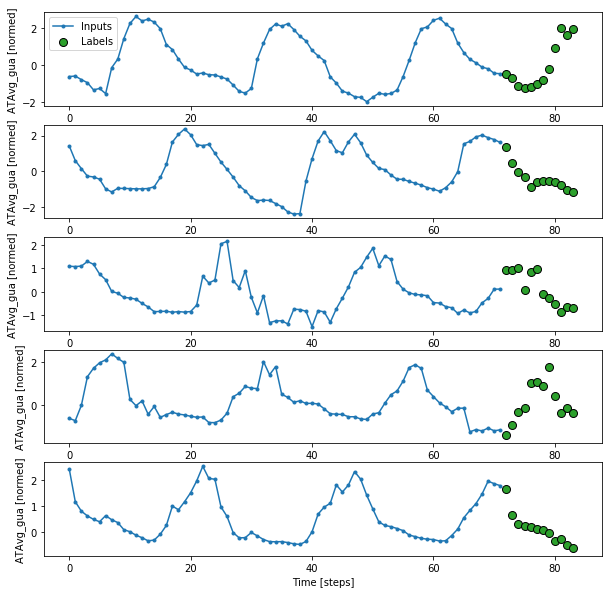

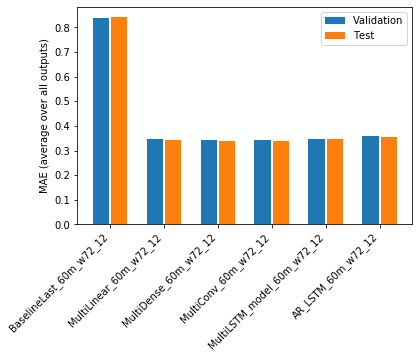

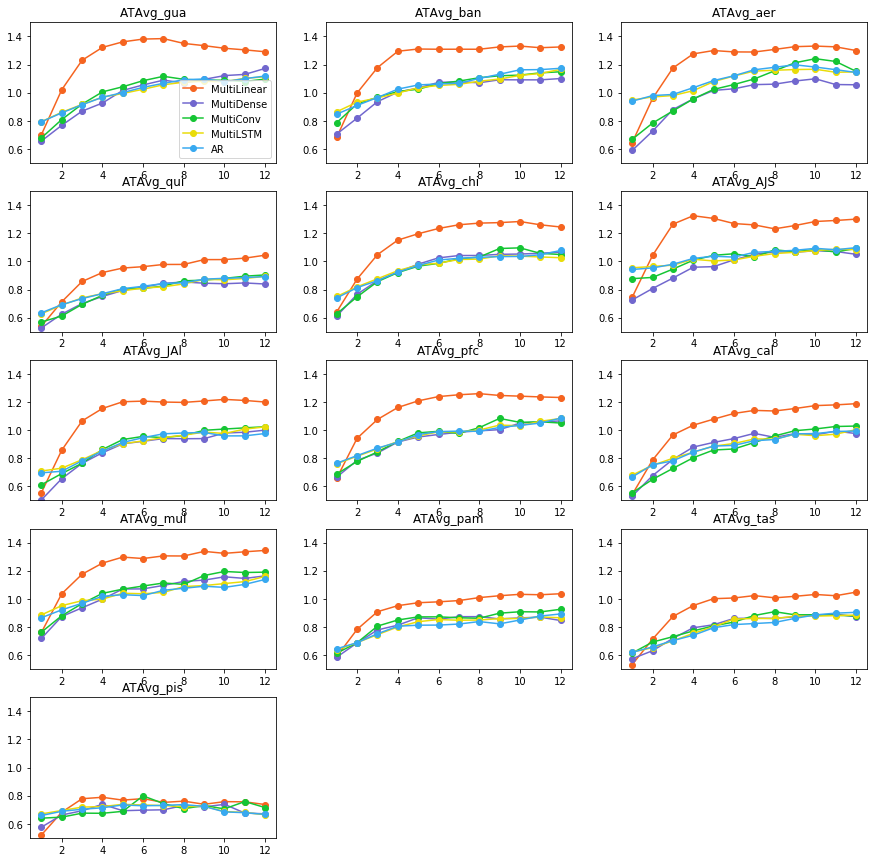

In [29]:
input_width = 72*time_steps
OUT_STEPS = 12*time_steps
performance = multi_models(station, path, num_features,input_width= input_width, OUT_STEPS=OUT_STEPS)
file = f'{path}/{station}_multi_{sample_freq}m_w{input_width}_{OUT_STEPS}_performance_times.csv'
plot_times(file, y0=0.5, y1=1.5)

### 72 h + 24h

322/322 [==============================] - 3s 9ms/step - loss: 0.3895 - mean_absolute_error: 0.3745


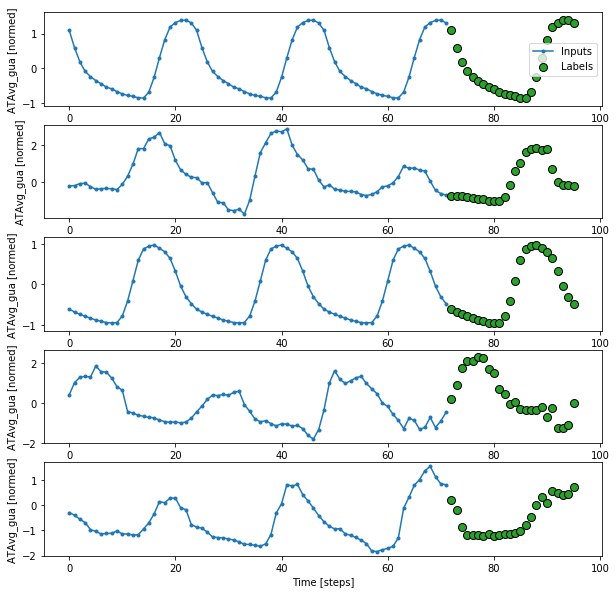

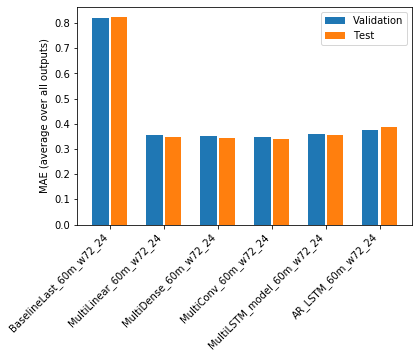

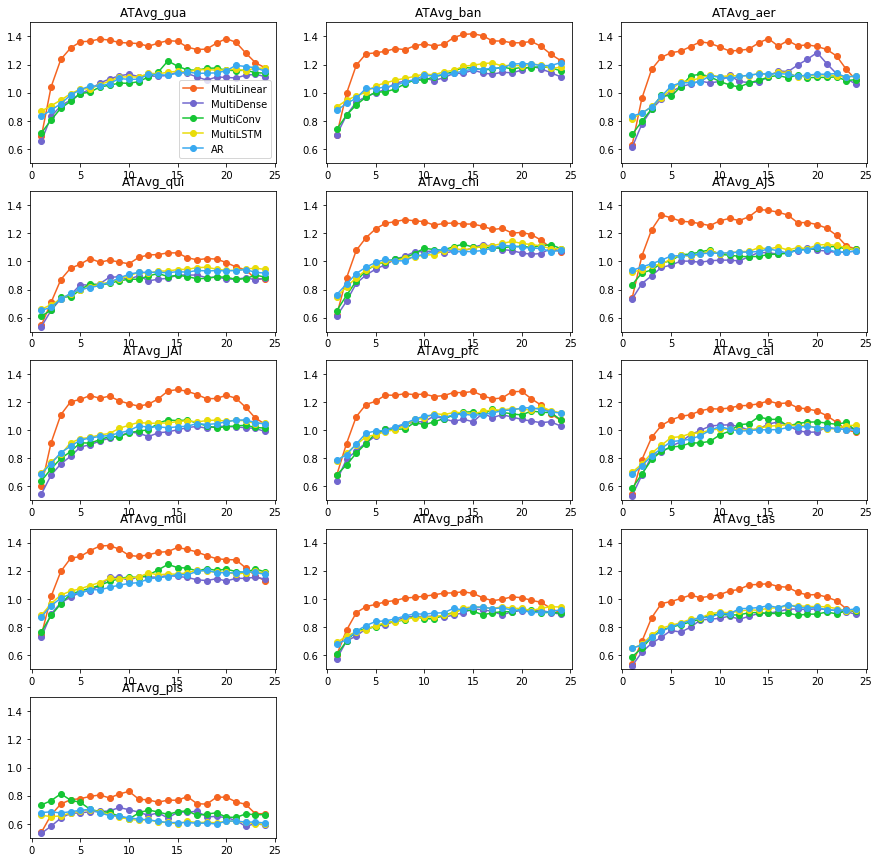

In [30]:
input_width = 72*time_steps
OUT_STEPS = 24*time_steps
performance = multi_models(station, path, num_features,input_width= input_width, OUT_STEPS=OUT_STEPS)
file = f'{path}/{station}_multi_{sample_freq}m_w{input_width}_{OUT_STEPS}_performance_times.csv'
plot_times(file, y0=0.5, y1=1.5)

### 72 h + 48h

321/321 [==============================] - 3s 9ms/step - loss: 0.4073 - mean_absolute_error: 0.3803


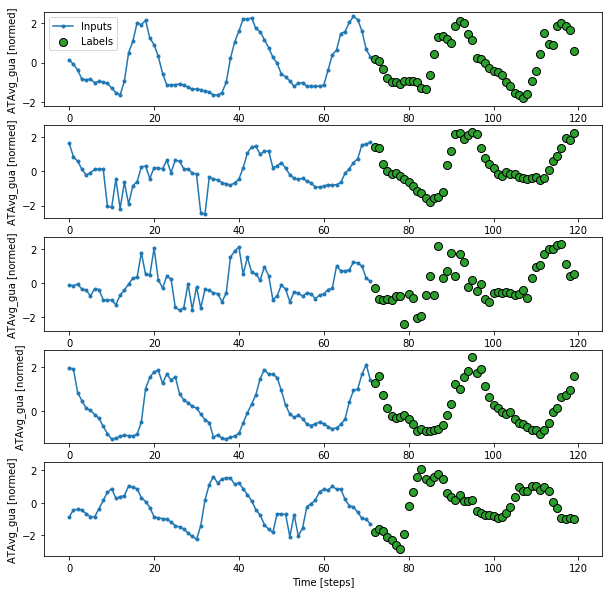

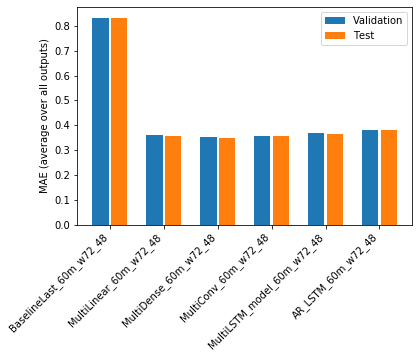

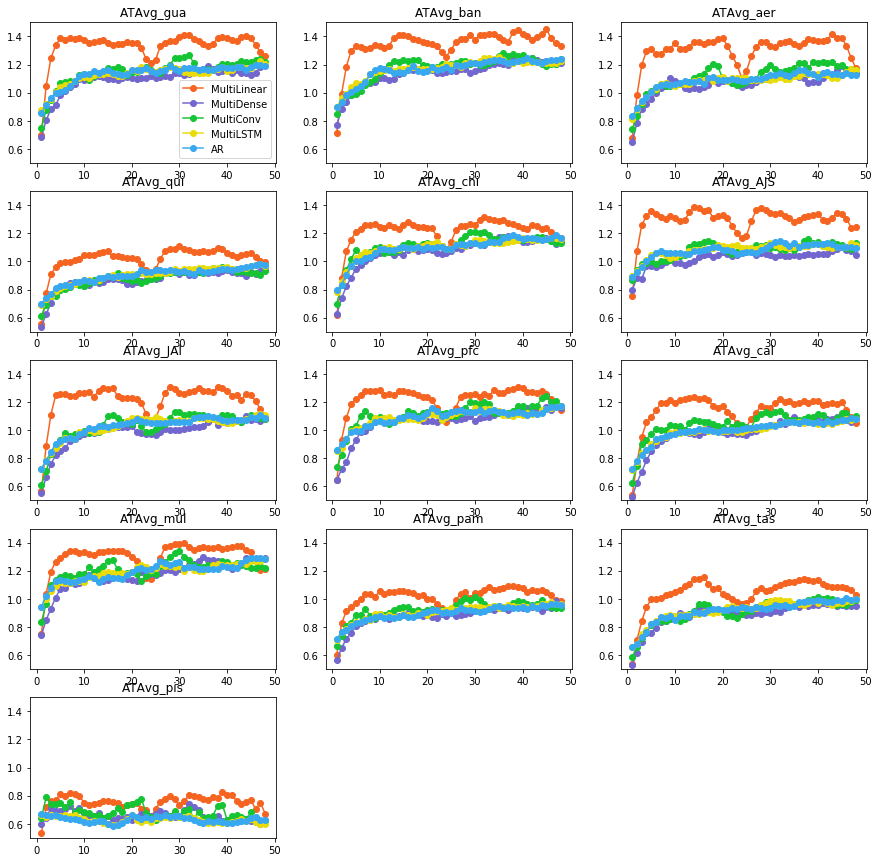

In [31]:
input_width = 72*time_steps
OUT_STEPS = 48*time_steps
performance = multi_models(station, path, num_features,input_width= input_width, OUT_STEPS=OUT_STEPS)
file = f'{path}/{station}_multi_{sample_freq}m_w{input_width}_{OUT_STEPS}_performance_times.csv'
plot_times(file, y0=0.5, y1=1.5)